In [71]:
import torch
from torch import nn
import numpy as np
import sklearn
from sklearn.datasets import make_circles, make_blobs
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import requests
import pathlib
from pathlib import Path
from timeit import default_timer as timer
from tqdm.auto import tqdm
import zipfile
import os
import random
from PIL import Image
from typing import Tuple, Dict, List

## 0. Set up device-agnostic code

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## 1. Get Data
`Note:` This is a subset of the food 101 dataset in pytorch built-in dataset
(3 classes of food and 10% of images)

In [3]:
# Set up path to a data folder
data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'

if image_path.is_dir():
    print(f'{image_path} already exists')
else:
    print(f'{image_path} does not exist, creating...')
    image_path.mkdir(parents=True,exist_ok=True)

# Download the actual data
with open(data_path / 'pizza_steak_sushi.zip', 'wb') as f:
    request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')
    print('Downloading data')
    f.write(request.content)

# Upzip the data
with zipfile.ZipFile(data_path/'pizza_steak_sushi.zip', 'r') as zip_ref:
    print('Unzipping pizza, steak and sushi data...')
    zip_ref.extractall(image_path)

data/pizza_steak_sushi does not exist, creating...
Unzipping pizza, steak and sushi data...


In [4]:
data_path

PosixPath('data')

## 2. Data prep and exploration

In [5]:
def walk_through_dir(dir_path):
    '''Walks through dir_path returning its contents'''
    for dirpath,dirnames,filenames in os.walk(dir_path):
        print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')


In [6]:
walk_through_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/test
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak
There are 3 directories and 0 images in data/pizza_steak_sushi/train
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak


In [7]:
# Set up train and testing paths
train_dir = image_path / 'train'
test_dir = image_path / 'test'


### 2.1 Visualizing an image

Write some code to:
1. Get all of the image paths
2. Pick a random image path using Python's random.choice()
3. Get the image class name `pathlib.Path.parent.stem`
4. Open the image with Python's PIL
5. Show hte image and print metadata

data/pizza_steak_sushi/test/steak/1302563.jpg
steak
Random image path: data/pizza_steak_sushi/test/steak/1302563.jpg
Image class: steak
Image height: 512
Image width: 512


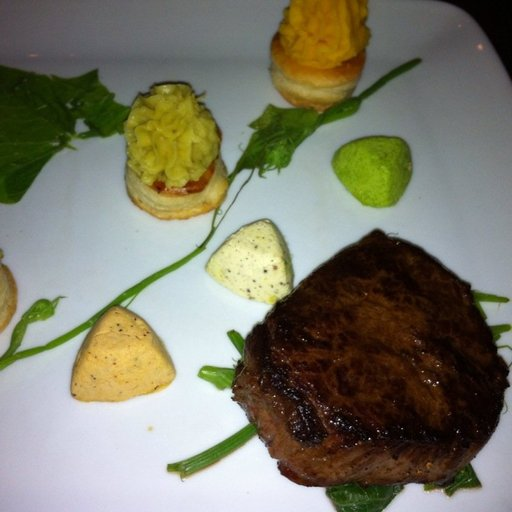

In [8]:
random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob('*/*/*.jpg'))

# 2. Pick a random image
random_image_path = random.choice(image_path_list)
print(random_image_path)

# 3. get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem
print(image_class)

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

(-0.5, 511.5, 511.5, -0.5)

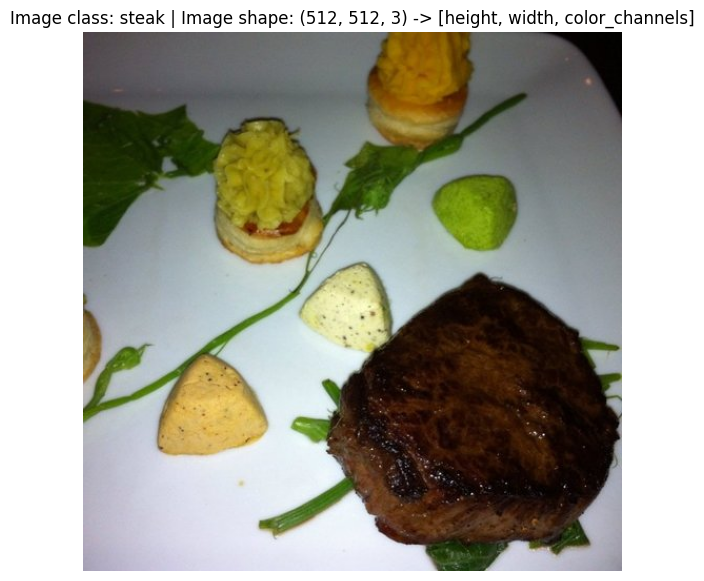

In [9]:
# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with plt
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f'Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]')
plt.axis(False)

## 3. Transforming Data

1. Turn target data into tensors
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we will call these dataset and dataloader

### 3.1 Transforming data with `torchvision.transforms`

In [10]:
# Write a tranform for image
data_transform = transforms.Compose(
    [# Resize our images to 64x64
    transforms.Resize(size=(64,64)),
    # Flip the images randomly on the horizontal axis
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()]
)

In [11]:
data_transform(img).dtype,data_transform(img).shape,

(torch.float32, torch.Size([3, 64, 64]))

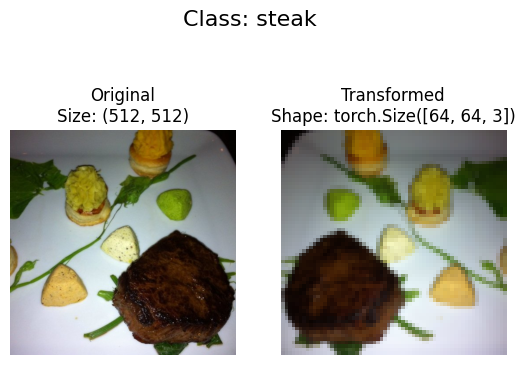

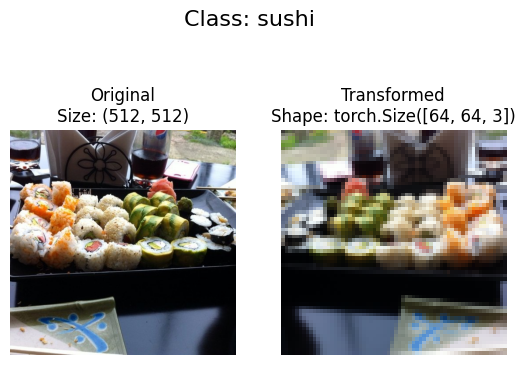

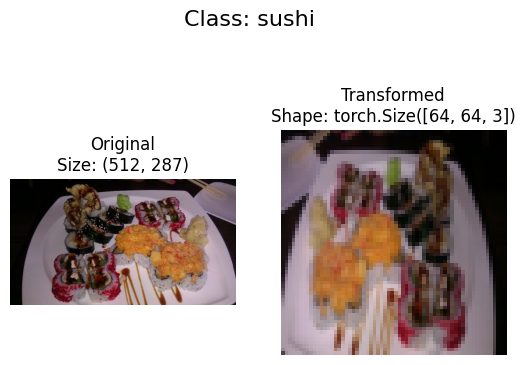

In [12]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            # Original image
            ax[0].imshow(f)
            ax[0].set_title(f'Original\nSize: {f.size}')
            ax[0].axis(False)

            # Transform and plot target image
            transformed_image = transform(f).permute(1,2,0) # note we will ned to change shape for matplotlib
            # the 'permute' function make sure the [colorchannel, height, width] turn into [height, width, colorchannel]
            ax[1].imshow(transformed_image)
            ax[1].set_title(f'Transformed\nShape: {transformed_image.shape}')
            ax[1].axis('off')

            fig.suptitle(f'Class: {image_path.parent.stem}', fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=42)

## 4. Option 1: Loading image data using `ImageFolder`

We can load image classification data using `torchvision.datasets.ImageFodler`

In [13]:
# Use image folder to create datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # This term is a tranform for the data
                                  target_transform=None) # This term is a transform for the label/target
test_data = datasets.ImageFolder(root=test_dir,
                                  transform=data_transform)
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [14]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [15]:
# Get class nams as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [19]:
# Check the length of dataset
len(train_data), len(test_data), train_data.samples[0]

(225, 75, ('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0))

In [27]:
# Index on teh train_data to get a single image and label
img, label = train_data[0][0], train_data[0][1]
img, label, img.shape, img.dtype, type(label)


(tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
          [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
          [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
          ...,
          [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
          [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
          [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],
 
         [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
          [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
          [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
          ...,
          [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
          [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
          [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],
 
         [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
          [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
          [0.0902, 0.0902, 0.0902,  ...,

In [29]:
# Rearrange the order dimensions
img_permute = img.permute(1,2,0)

# Print out different shapes
img.shape, img_permute.shape, img.numpy().shape

(torch.Size([3, 64, 64]), torch.Size([64, 64, 3]), (3, 64, 64))

Text(0.5, 1.0, 'pizza')

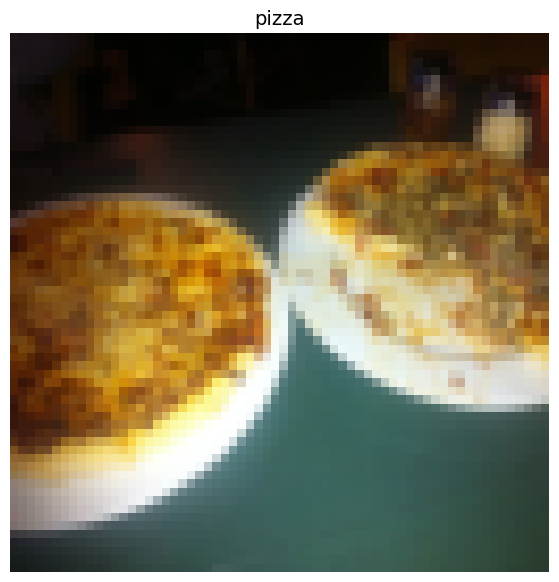

In [30]:
# Plot the image
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis('off')
plt.title(class_names[label], fontsize=14)

### 4.1 Turn loaded images into `DataLoader`'s

A `DataLoader` helps turn `Datase`'s into interables and we can customize the `batch_size` so the model can see the `batch_size` images at a time

In [43]:
# Turn datasets into dataloader
BATCH_SIZE = 1
train_data_loader = DataLoader(dataset=train_data,
                               batch_size=BATCH_SIZE,
                               num_workers=os.cpu_count(),
                               shuffle=True)
test_data_loader = DataLoader(dataset=test_data,
                               batch_size=BATCH_SIZE,
                               num_workers=os.cpu_count(),
                               shuffle=False)

In [44]:
train_data_loader,len(train_data_loader)

(<torch.utils.data.dataloader.DataLoader at 0x7fc0ff05ae30>, 225)

In [46]:
img, label = next(iter(train_data_loader))
label, img.shape

(tensor([2]), torch.Size([1, 3, 64, 64]))

## 5. Option 2: Loading image data with a Custom `Dataset`

1. Be able to load images from file
2. Be able to get class names from the dataset
3. Be able to get class as dictionaries from dataset


In [52]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx #

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

1. Get the class name using `os.scandir()` to traverse a target directory (ideally the directory is in standard image classification format)
2. Raise an error if the class name is not found (if this happends, there might be something wrong with the structure of the directories)
3. Turn the class names into a dict and list and return them

In [55]:
# Set up path for target directory
target_directory = train_dir

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

['pizza', 'steak', 'sushi']

In [58]:
for i in os.scandir(target_directory): # Note: this function does NOT give output in sorted order. NEED to add sorted() function
    print(i,i.name)

<DirEntry 'sushi'> sushi
<DirEntry 'pizza'> pizza
<DirEntry 'steak'> steak


In [69]:
def find_classes(directory:str) -> Tuple[List[str], dict[str,int]]:
    # 1. Get the class name by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir()) # Note: the sorted function will automatically return a LIST
    # 2. raise an error if class nams could not be found
    if not classes:
        raise FileNotFoundError(f'Could not find any classes in {directory}...CHECK file structure')

    # 3. Create a dictionary of index labels
    class_to_idx = {class_name:i for i, class_name in enumerate(classes)}
    return classes, class_to_idx

In [70]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom dataset to replicate `ImageFolder`

We want to:
1. Subclass `torch.utils.Dataset`
2. init our subclass with a target directory (the directory we'd like to get data from) as well as a transform if we'd like to transform our data.
3. Create several attributes:
    * path - paths of our images
    * transform - the transform we'd liek to use
    * classes - a list of the target classes
    * class_to_idx - a dict of the targe classes mapped to integer labels
4. Create a functino to `load_images()`, this function will open up an image
5. Overwrite the `__len__()` method to return the length of our dataset
6. Overwrite the `__getitem__()` method to return a given sample when passed an index




In [91]:
# 1. subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    # 2. Initialize
    def __init__(self,
                 targ_dir:str,
                 transform=None):
        # 3. Create class attribute
        # Get all the image paths
        self.paths = list(pathlib.Path(targ_dir).glob('*/*.jpg'))
        # Set up transform
        self.transform = transform
        # Create classes and class_to_idx
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Create a function to load images
    def load_image(self, index:int) -> Image.Image:
        '''Opens an image via a path and returns it'''
        image_path = self.paths[index]
        return Image.open(image_path)

    # 5. Overwirte the __len__() method
    def __len__(self) -> int:
        '''returns total number of samples'''
        return len(self.paths)

    # 6. Overwrite the __getitem__() method
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        img = self.load_image(index)
        class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/img.jpg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx
        else:
            return img, class_idx


In [92]:
img, label = train_data[0]
img,label

(tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
          [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
          [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
          ...,
          [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
          [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
          [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],
 
         [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
          [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
          [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
          ...,
          [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
          [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
          [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],
 
         [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
          [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
          [0.0902, 0.0902, 0.0902,  ...,

In [93]:
# Create a transform
train_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])
test_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [96]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                      transform=test_transforms)
train_data_custom,test_data_custom

(<__main__.ImageFolderCustom at 0x7fc0fc5d9240>,
 <__main__.ImageFolderCustom at 0x7fc0fc5d80d0>)

In [101]:
len(train_data_custom), len(test_data_custom), train_data_custom.classes,train_data_custom.class_to_idx

(225, 75, ['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [103]:
# Check for quality between orginal ImageFolder Dataset and ImageFodlerCustom Dataset
train_data_custom.classes == train_data.classes, test_data_custom.classes == test_data.classes

(True, True)

### 5.3 Create a function to display random images

1. Take in a `Dataset` and a number of other parameters such as class names and how many images to visualize
2. To prevent the display getting out of hand, Cap the number of images to see at 10
3. Set random seed
4. Get a list of random sample indices from the target dataset
5. Set up matplotlib plot
6. Loop thorught the sample images and plot it with matplotlib
7. Make sure the dimensions of our image line up with matplotlib (HWC)


In [106]:
# 1. Create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str]=None,
                          n:int = 10,
                          display_shape: bool=True,
                          seed: int=None):
    # 2. Adjust display if n is too high
    if n > 10:
        n = 10
        display_shape = False
        print(f'Number should not be greater than 10, setting the number to 10 and removing shape display')

    # 3. Random Seed
    if seed:
        random.seed(seed)

    # 4. Get of random sample indices
    random_sample_idx = random.sample(range(len(dataset)), k=n)

    # 5. Set up a matplotlib plot
    plt.figure(figsize=(16,8))

    # 6. Loop through the indices and plot them
    for i, targ_sample in enumerate(random_sample_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust dimensions for plotting
        targ_image_adjust = targ_image.permute(1,2,0)

        # Plot adjusted samples
        plt.subplot(1,n,i+1)
        plt.imshow(targ_image_adjust)
        plt.axis('off')
        title = ''
        if classes:
            title = f'class: {classes[targ_label]}'
            if display_shape:
                title = title + f'\nshape: {targ_image_adjust.shape}'
        plt.title(title)

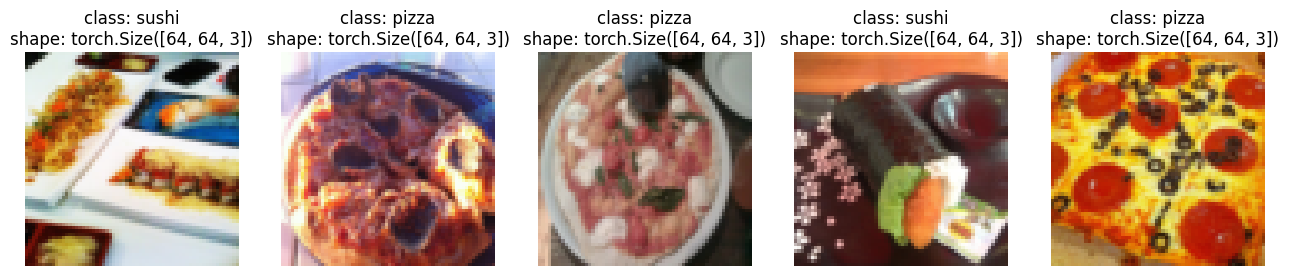

In [108]:
# Display random images from the ImageFolder created dataset
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=42)

Number should not be greater than 10, setting the number to 10 and removing shape display


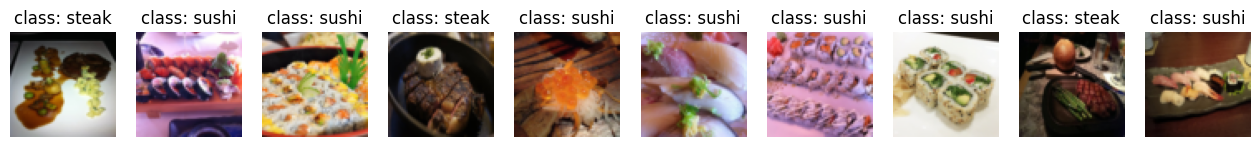

In [109]:
# display images from the custom dataset
display_random_images(train_data_custom,
                      n=20,
                      classes=class_names,
                      seed=42)

### 5.4 Turn custom loaded images into `DataLoader`'s

In [115]:
BATCH_SIZE = 32
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True)
test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                     batch_size=BATCH_SIZE)
train_dataloader_custom,

(<torch.utils.data.dataloader.DataLoader at 0x7fc0f5bc9de0>,)

In [118]:
img_custom, label_custom = next(iter(train_dataloader_custom))
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## 6. Other forms of transforms

Data augmentation is the process of artifically addingdiversity to your training data.

in the case of image data, this mean applying various image transfomrations to the images

This practice hopefully results in a model that is more generalizable to unseen data


In [119]:
# Trivial Augment
train_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])

In [121]:
# Get all image paths
image_path_list = list(image_path.glob('*/*/*.jpg'))
image_path_list[:10]


[PosixPath('data/pizza_steak_sushi/test/sushi/2276986.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/1987407.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/1742201.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/2715127.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/2394442.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/1600999.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/1680893.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/1172255.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/1230335.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/2741434.jpg')]

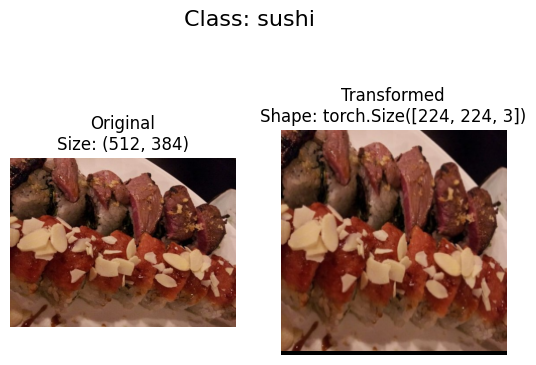

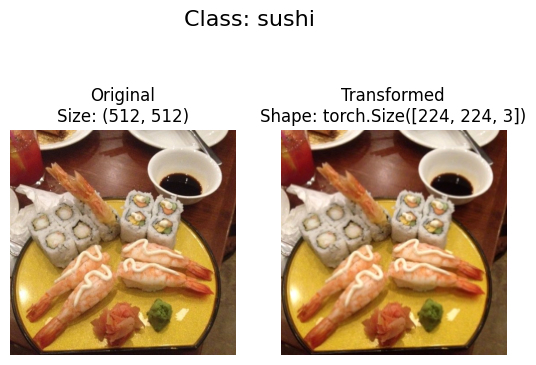

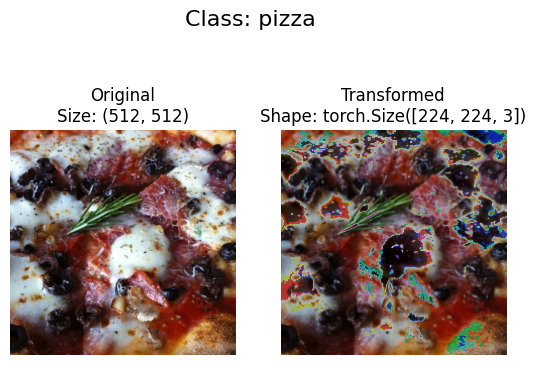

In [123]:
# Plot random transformed images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transform,
    n=3,
    seed=None
)

## 7. model 0: TinyVGG without data augmentation

Replicat4e TinyVGG architecture from teh CNN Explainer website

### 7.1 Creating transforms and loading data for Model 0

In [260]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [261]:
# 1. Load and transform data
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                         transform=simple_transform)

# 2. Turn datasets into dataloaders

# Set up batch size and num_workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create dataloaders
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)
test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS)

### 7.2 Create TinyVGG model class

In [262]:
class TinyVGG(nn.Module):
    def __init__(self, input_shape,
                 hidden_units,
                 output_shape):
        super().__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*13*13,
                      out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        return x

In [263]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # This indicates the numbe of color channels in the images
                  hidden_units=10,
                  output_shape=3).to(device)


### 7.3 Try a forward pass on a single image (to test the model)

In [264]:
# Getting a single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch, label_batch = image_batch.to(device), label_batch.to(device)
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [265]:
# Try a forward pass
model_0(image_batch)

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4668e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9131e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6415e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7979e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1816e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3995e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1469e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.1665e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

### 7.4 Use `torchinfo` to get an idea of the shapes going through our model


In [266]:
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary

In [267]:
summary(model_0, input_size=[1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

### 7.5 Training loop and testing loop

*   `train_step()`
*   `test_step()`



In [268]:
# Train step function
def train_step(model:torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device=device):

    # Put the model into train mode
    model.train()

    # Set up train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through dataloader batches
    for batch, (X,y) in enumerate(dataloader):
        # Send the data to the target device
        X, y = X.to(device), y.to(device)

        # 1. Forward Pass
        y_pred = model(X) # This is logits

        # 2. Calculate the loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss Backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate the accracy and accumulate
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class==y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and acc per batch
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    return train_loss, train_acc

In [269]:
train_step(model_0,
           train_data_loader,
           loss_fn,
           optimizer)

(1.097707470258077, 0.3466666666666667)

In [289]:
# Create a test step
def test_step(model:torch.nn.Module,
              dataloader:torch.utils.data.DataLoader,
              loss_fn:torch.nn.Module,
              device=device):
    # Put model into eval mode
    model.eval()

    # Set up test loss and test accuracy value
    test_loss, test_acc = 0, 0

    # Turn on inference mode
    with torch.inference_mode():
        # Loop through dataloader
        for batch, (X,y) in enumerate(dataloader):
            # Sent data to target device
            X, y  = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate the loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate the accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

        # Adjust metrics to get average loss and acc per batch
        test_loss /= len(dataloader)
        test_acc /= len(dataloader)

        return test_loss, test_acc

### 7.6 Create a `train()` function to combine `train_step()` and `test_step()`

In [300]:
# 1. Create a train function that takes in various model parameters + optimizer + dataloader + loss_fn ...
def train(model:torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device=device):
    # 2. Create an empty results dictionary
    results = {'train_loss':[],
               'train_acc':[],
               'test_loss':[],
               'test_acc':[]}
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=train_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)
        # 4. print out what is happening
        print(f'Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}')

        # 5. Update results dictionary
        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)
    # 6. Return the filled resulots at the end of epochs
    return results

### 7.7 Train and evaluate model 0

In [301]:
# Set random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreating an instance of TinyVGG
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# Set up loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

# Start the timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)
# End the timer and print out the time it took
end_time = timer()
print(f'Total training time: {end_time-start_time:.3f} seconds')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1063 | Train acc: 0.3047 | Test loss: 1.0956 | Test acc: 0.5703
Epoch: 1 | Train loss: 1.0835 | Train acc: 0.4453 | Test loss: 1.0808 | Test acc: 0.4023
Epoch: 2 | Train loss: 1.1063 | Train acc: 0.2812 | Test loss: 1.0694 | Test acc: 0.4023
Epoch: 3 | Train loss: 1.0755 | Train acc: 0.4766 | Test loss: 1.0544 | Test acc: 0.5234
Epoch: 4 | Train loss: 1.0664 | Train acc: 0.4023 | Test loss: 1.0395 | Test acc: 0.4062
Total training time: 15.555 seconds


In [302]:
model_0_results

{'train_loss': [1.106319084763527,
  1.0835425406694412,
  1.1063105911016464,
  1.0754823833703995,
  1.066375970840454],
 'train_acc': [0.3046875, 0.4453125, 0.28125, 0.4765625, 0.40234375],
 'test_loss': [1.0956130176782608,
  1.0808220133185387,
  1.0693800300359726,
  1.0543669164180756,
  1.039500042796135],
 'test_acc': [0.5703125, 0.40234375, 0.40234375, 0.5234375, 0.40625]}

### 7.8 plot the loss curve of model_0



In [303]:
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [304]:
def plot_loss_curves(results:Dict[str,List[float]]):
    # Get the loss values of the rsults dictionary (training and testing)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the acc values
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs are there
    epochs = range(len(results['train_loss']))

    # Set up plot
    plt.figure(figsize=(15,7))

    # plot the loss
    plt.subplot(1,2,1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot the acc
    plt.subplot(1,2,2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();



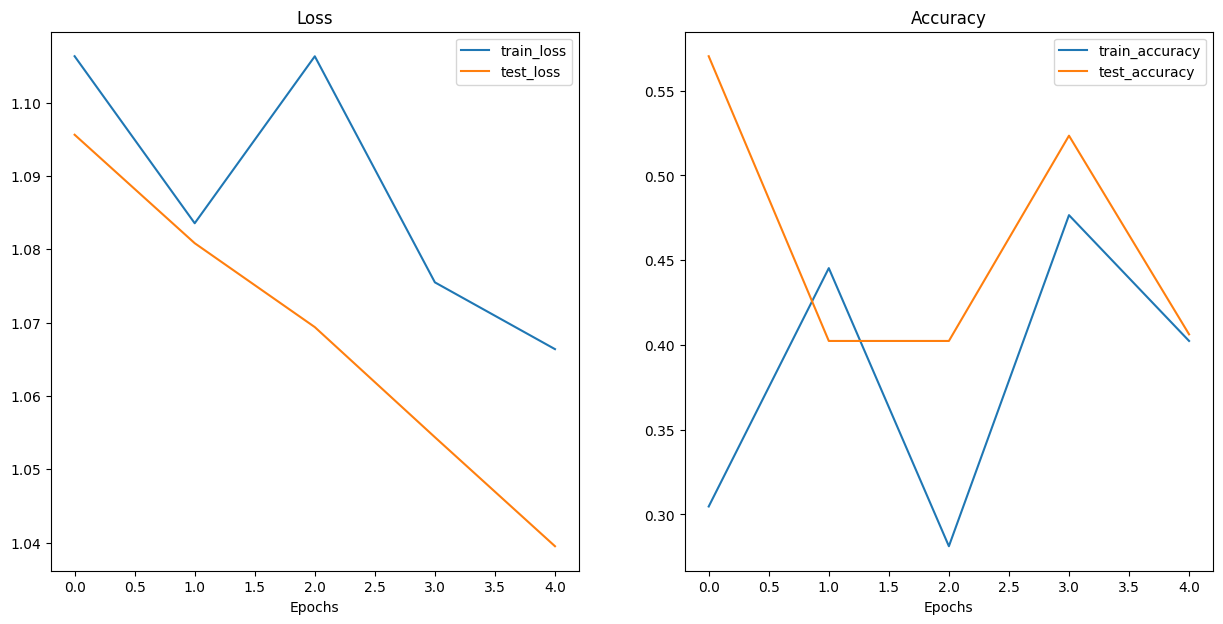

In [305]:
plot_loss_curves(model_0_results)

## 8. What should an ideal loss curve look like?



## 9. Model 1: TinyVGG with Data Augmentation

Using the same model as before with some data augmentation

### 9.1 Create transform with data augmentation

In [320]:
# Create training transform with TrivialAugment

train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

### 9.2 Create train and test dataset and dataloader with data augmentation

In [321]:
# Turn image folders into dataset
train_data_augmented = datasets.ImageFolder(root=train_dir,
                                            transform=train_transform_trivial)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                            transform=test_transform_simple)

In [322]:
# Turn datasets into dataloaders
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)


### 9.3 Construct and train model 1

We will use the same model architecture but with aagumented training data

In [323]:
# Create model 1 and send it to the target device
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data_augmented.classes)).to(device)

In [324]:
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [325]:
# Create a loss_fn and an optimizer and train + test the model

In [326]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set epochs
NUM_EPOCHS = 5

# Loss_fn
loss_fn = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001)

# Start the timer
start_time = timer()

# Train model 1
model_1_results = train(model=model_1,
                train_dataloader=train_dataloader_augmented,
                test_dataloader=test_dataloader_simple,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=NUM_EPOCHS,
                device=device)

# End the timer and print out how long it took
end_time = timer()
print(f'Total Time for model 1: {end_time-start_time} seconds')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1049 | Train acc: 0.2500 | Test loss: 1.0937 | Test acc: 0.4258
Epoch: 1 | Train loss: 1.0792 | Train acc: 0.4258 | Test loss: 1.0762 | Test acc: 0.4258
Epoch: 2 | Train loss: 1.1276 | Train acc: 0.3047 | Test loss: 1.1214 | Test acc: 0.3047
Epoch: 3 | Train loss: 1.0823 | Train acc: 0.4258 | Test loss: 1.1012 | Test acc: 0.3047
Epoch: 4 | Train loss: 1.1020 | Train acc: 0.3047 | Test loss: 1.0911 | Test acc: 0.3047
Total Time for model 1: 16.86464745899866 seconds


### 9.4 Plot the loss curves


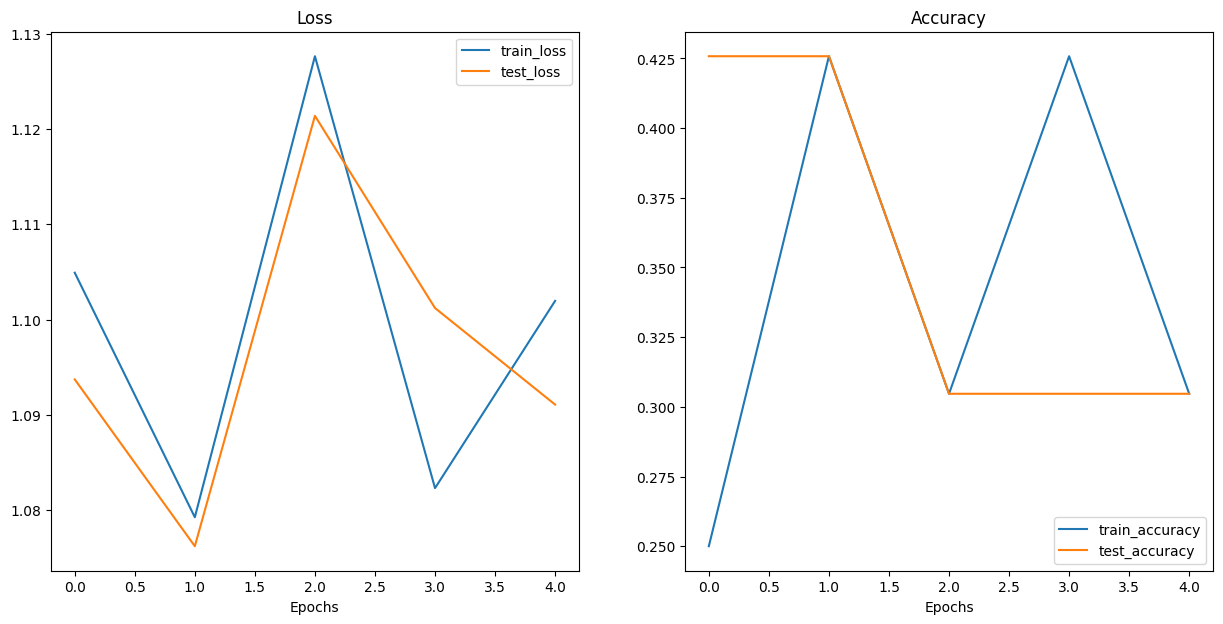

In [327]:
plot_loss_curves(model_1_results)

## 10. Compare model results

Ways to do this:
1. Hard coding (what we are doing now)
2. PyTorch + Tensorboard
3. Weights & Biases
4. MLFlow

In [330]:
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.106319,0.304688,1.095613,0.570312
1,1.083543,0.445312,1.080822,0.402344
2,1.106311,0.281250,1.069380,0.402344
3,1.075482,0.476562,1.054367,0.523438
4,1.066376,0.402344,1.039500,0.406250


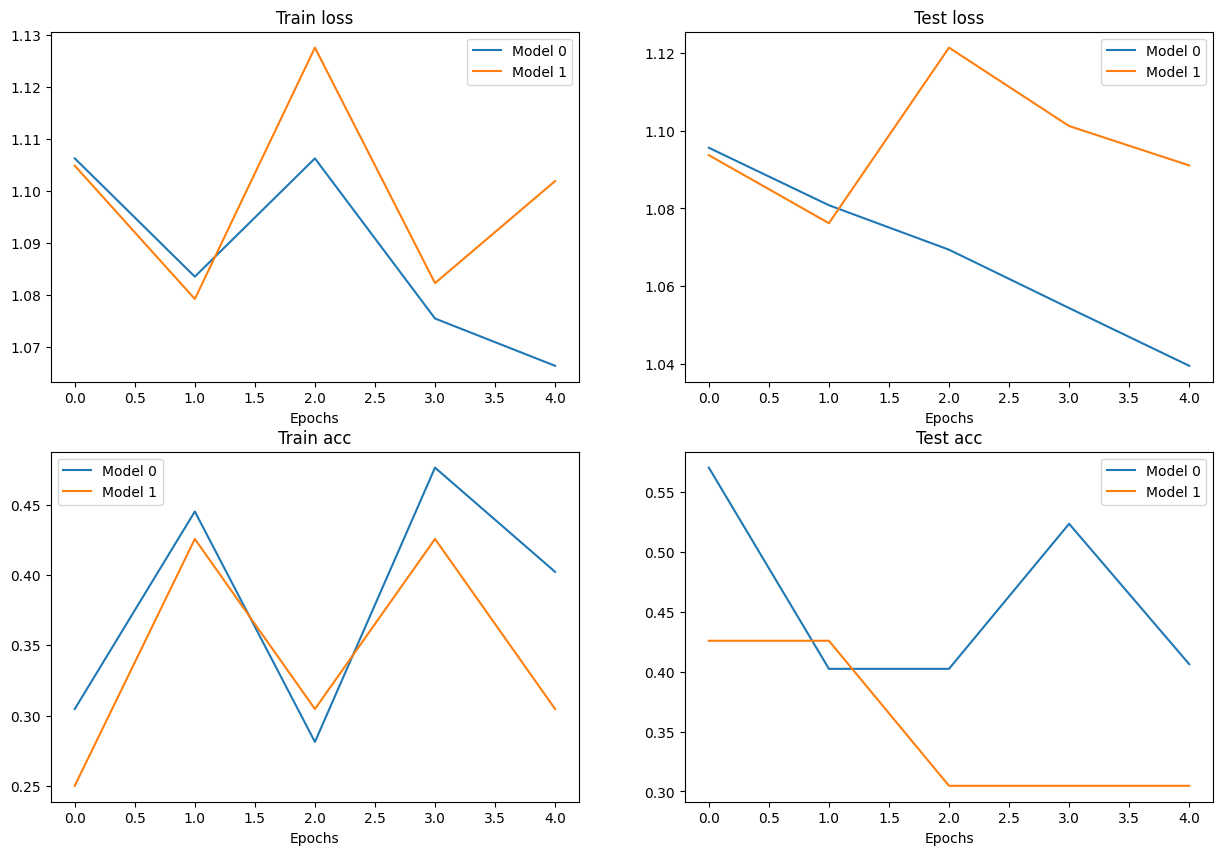

In [339]:
# Set up a plot
plt.figure(figsize=(15,10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2,2,1)
plt.plot(epochs, model_0_df['train_loss'], label='Model 0')
plt.plot(epochs, model_1_df['train_loss'], label='Model 1')
plt.title('Train loss')
plt.xlabel('Epochs')
plt.legend()

# Plot the test loss
plt.subplot(2,2,2)
plt.plot(epochs, model_0_df['test_loss'], label='Model 0')
plt.plot(epochs, model_1_df['test_loss'], label='Model 1')
plt.title('Test loss')
plt.xlabel('Epochs')
plt.legend()

# Plot train acc
plt.subplot(2,2,3)
plt.plot(epochs, model_0_df['train_acc'], label='Model 0')
plt.plot(epochs, model_1_df['train_acc'], label='Model 1')
plt.title('Train acc')
plt.xlabel('Epochs')
plt.legend()

# Plot the test acc
plt.subplot(2,2,4)
plt.plot(epochs, model_0_df['test_acc'], label='Model 0')
plt.plot(epochs, model_1_df['test_acc'], label='Model 1')
plt.title('Test acc')
plt.xlabel('Epochs')
plt.legend()


## 11. Making a prediction on a custom image
`Note:` to make a prediction on a custom image we NEED to:


*   Load the image and turn it into a tensor
*   Make sure the image was the same datatype as the model (torch.float32)
*   make sure the image was the same shape as the data the mdoel was trained on (3,64,64) with a batch size (1,3,64,64)
*   Make sure the image was on the same device as our model



In [340]:
# Download custom image
custom_image_path = data_path / 'cust_img.jpg'

if not custom_image_path.is_file():
    with open(custom_image_path, 'wb') as f:
        # When downloading, need to use the 'raw' file link
        request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg')
        print(f'Downloading {custom_image_path}...')
        f.write(request.content)
else:
    print(f'{custom_image_path} already exists')

### 11.1 Loading in a custom image with PyTorch

Make sure the custom image is in the same format as the data that the model was trained to

* dtype = float32
* shape 64x64x3
* On the right device

In [343]:
# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))
custom_image_uint8

tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

(-0.5, 3023.5, 4031.5, -0.5)

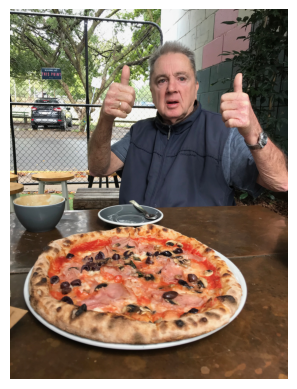

In [345]:
plt.imshow(custom_image_uint8.permute(1,2,0))
plt.axis(False)

In [347]:
custom_image_uint8, custom_image_uint8.shape,custom_image_uint8.dtype

(tensor([[[154, 173, 181,  ...,  21,  18,  14],
          [146, 165, 181,  ...,  21,  18,  15],
          [124, 146, 172,  ...,  18,  17,  15],
          ...,
          [ 72,  59,  45,  ..., 152, 150, 148],
          [ 64,  55,  41,  ..., 150, 147, 144],
          [ 64,  60,  46,  ..., 149, 146, 143]],
 
         [[171, 190, 193,  ...,  22,  19,  15],
          [163, 182, 193,  ...,  22,  19,  16],
          [141, 163, 184,  ...,  19,  18,  16],
          ...,
          [ 55,  42,  28,  ..., 107, 104, 103],
          [ 47,  38,  24,  ..., 108, 104, 102],
          [ 47,  43,  29,  ..., 107, 104, 101]],
 
         [[119, 138, 147,  ...,  17,  14,  10],
          [111, 130, 145,  ...,  17,  14,  11],
          [ 87, 111, 136,  ...,  14,  13,  11],
          ...,
          [ 35,  22,   8,  ...,  52,  52,  48],
          [ 27,  18,   4,  ...,  50,  49,  44],
          [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8),
 torch.Size([3, 4032, 3024]),
 torch.uint8)

### 11.2 Making a prediction on a custom image with a trained PyTorch Model

In [349]:
# Try to make a prediction on an image on uint8
# model_1.eval()
# with torch.inference_mode():
#     model_1(custom_image_uint8.to(device))

In [357]:
# Load in the custom image and convert to torch.float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255.
custom_image

tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..., 0.0549, 0.0510, 0.

In [356]:
# This will cause a shape issue
# model_1.eval()
# with torch.inference_mode():
#     model_1(custom_image.to(device))

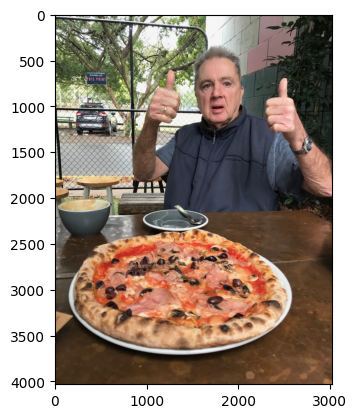

In [358]:
plt.imshow(custom_image.permute(1,2,0))

In [359]:
# Create a transform pipeline to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64,64))
])
# Transform target image
custom_image_transformed = custom_image_transform(custom_image)
custom_image.shape, custom_image_transformed.shape

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


(torch.Size([3, 4032, 3024]), torch.Size([3, 64, 64]))

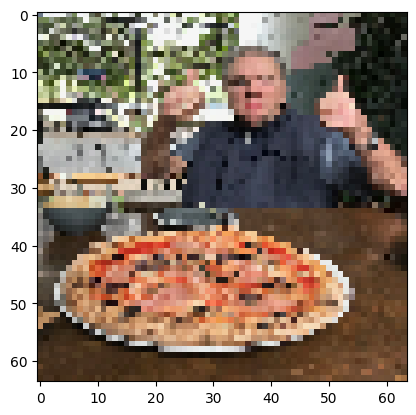

In [360]:
plt.imshow(custom_image_transformed.permute(1,2,0))

In [362]:
model_1.eval()

with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed.unsqueeze(dim=0).to(device))

In [364]:
class_names[custom_image_pred.argmax()]

'pizza'

In [366]:
custom_image_pred.argmax().item()

0

### 11.3 Putting ucstom image prediction together: building a function


In [370]:
def pred_and_plot_image(model:torch.nn.Module,
                        image_path:str,
                        class_names:List[str]=None,
                        transform=None,
                        device=device):
    # Load the image
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # Divide the target image pixel values by 255 to get them between (0,1)
    target_image /= 255.

    # Transform if necessary
    if transform:
        target_image = transform(target_image)

    # Make sure the model and the image is on the target device
    model.to(device)
    target_image = target_image.to(device)

    # Turn on eval/inference mode and make a prediction
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image (this is the batch dimension)
        target_image = target_image.unsqueeze(0)

        # Make a prediction on the image with an extra dimension
        target_image_pred = model(target_image)

    # Convert logits to pred prob
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # Convert pred prob to label
    target_image_pred_labels = torch.argmax(target_image_pred_probs,dim=1)

    plt.imshow(target_image.squeeze().permute(1,2,0)) # remove the extra dimension and rearrange the shape
    if class_names:
        title = f'Pred:{class_names[target_image_pred_labels]} | Prob: {target_image_pred_probs.max().cpu():.3f}'
    else:
        title = f'Pred:{target_image_pred_labels} | prob: {target_image_pred_probs.max().cpu():.3f}'
    plt.title(title)
    plt.axis(False)




/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


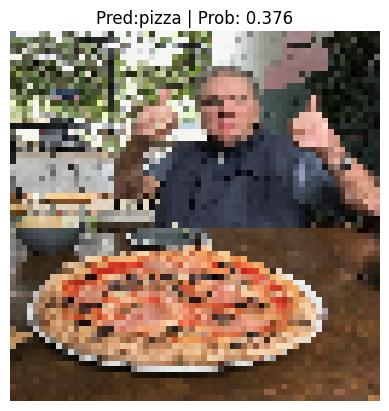

In [373]:
# pred on custom image
pred_and_plot_image(model=model_1,
                    image_path=str(custom_image_path),
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)

In [368]:
custom_image_path

PosixPath('data/cust_img.jpg')